In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import cm
from PIL import Image
from pykanto.dataset import KantoData
from pykanto.parameters import Parameters
from pykanto.utils.compute import with_pbar
from pykanto.utils.io import load_dataset
from pykanto.utils.paths import ProjDirs, link_project_data
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from copy import deepcopy
import git


## Create project directories object and import dataset

In [54]:
PROJECT_ROOT = Path(
    git.Repo(".", search_parent_directories=True).working_tree_dir
)
DATA_LOCATION = Path("/data/zool-songbird/shil5293/data/wytham-great-tit")
link_project_data(DATA_LOCATION, PROJECT_ROOT / "data")
DATASET_ID = "GRETI_2021"

segmented_dir = PROJECT_ROOT / "data" / "segmented" / DATASET_ID.lower()
DIRS = ProjDirs(PROJECT_ROOT, segmented_dir, DATASET_ID, mkdir=True)

    link_project_data() failed: the destination directory is not empty.


## Load dataset, check that it works

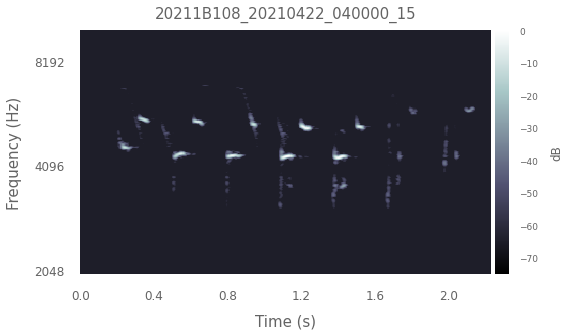

In [57]:
# Load existing dataset
dataset_path = DIRS.DATA / "datasets" / DATASET_ID / f"{DATASET_ID}.db"
dataset = load_dataset(dataset_path, DIRS)
dataset.plot(dataset.data.index[5])

## Read class labels from a csv file 
(the one containing class labels from the interactive app)

In [58]:
# Use a csv file containing a class_label column
# (here 'type_label', it's an old version)
csv_dataset = DIRS.DATA / "datasets" / DATASET_ID / f"{DATASET_ID}_VOCS.csv"
newlabs = pd.read_csv(csv_dataset, index_col=0)["type_label"]

if 'class_label' not in dataset.data:
    dataset.data.insert(2, "class_label", np.nan)

for i in with_pbar(dataset.data.index, desc="Finding matching indexes"):
    for j in newlabs.index:
        if j in i and not pd.isnull(newlabs.loc[j]):
            dataset.data.loc[i, "class_label"] = str(int(newlabs.loc[j]))


Finding matching indexes:   0%|          | 0/35177 [00:00<?, ?it/s]

## Save dataset

In [60]:
dataset.save_to_disk()
dataset.to_csv(dataset.DIRS.DATASET.parent)

Saved dataset to /data/zool-songbird/shil5293/projects/greti-main/data/datasets/GRETI_2021/GRETI_2021.db


## Append datasets together

In [64]:

# TODO: point to raw and segmented data from both the source datraframes!

DATASET_ID_0 = "GRETI_2020"
segmented_dir_0 = PROJECT_ROOT / "data" / "segmented" / DATASET_ID.lower()
DIRS_0 = ProjDirs(PROJECT_ROOT, segmented_dir_0, DATASET_ID, mkdir=True)
dataset_path_0 = DIRS_0.DATA / "datasets" / DATASET_ID_0 / f"{DATASET_ID_0}.db"
dataset_0 = load_dataset(dataset_path_0, DIRS_0)

DATASET_ID_1 = "GRETI_2021"
segmented_dir_1 = PROJECT_ROOT / "data" / "segmented" / DATASET_ID.lower()
DIRS_1 = ProjDirs(PROJECT_ROOT, segmented_dir_1, DATASET_ID_1, mkdir=True)
dataset_path_1 = DIRS_1.DATA / "datasets" / DATASET_ID_1 / f"{DATASET_ID_1}.db"
dataset_1 = load_dataset(dataset_path_1, DIRS_1)

DATASET_ID_J = "GRETI_2021-22"
DIRS_DERIVED = ProjDirs(PROJECT_ROOT, segmented_dir_0, DATASET_ID_J, mkdir=True)

joined_data = pd.concat([dataset_0.data, dataset_1.data])
joined_files = pd.concat([dataset_0.files, dataset_1.files])

joined_dataset = deepcopy(dataset_0)
joined_dataset.data, joined_dataset.files = joined_data, joined_files
joined_dataset.DIRS = DIRS_DERIVED

# Save
joined_dataset.save_to_disk()
joined_dataset.to_csv(joined_dataset.DIRS.DATASET.parent)


DATASET_ID = DATASET_ID_J
DIRS = ProjDirs(PROJECT_ROOT, segmented_dir_0, DATASET_ID, mkdir=True)
dataset_path = DIRS.DATA / "datasets" / DATASET_ID / f"{DATASET_ID}.db"
dataset = load_dataset(dataset_path, DIRS, relink_data=False)
dataset.plot(dataset.data.index[300])

NameError: name 'deepcopy' is not defined

# Export training data

In [80]:
# ──── SUBSAMPLE DATASET FOR MODEL TRAINING ─────────────────────────────────────
"""
This create a unique song class label for each vocalisation in the dataset (a
combination of the ID and the label)

"""
# Settings:
min_sample = 10

# Remove rows from song types with fewer than 10 songs
ss_data = (
    dataset.data.query("noise == False")
    .groupby(["ID", "class_label"])
    .filter(lambda x: len(x) >= min_sample)
    .copy()
)

# Sample 10 songs per type and bird
sbs_data = pd.concat(
    [
        data.sample(n=min_sample)
        for _, data in ss_data.groupby(["ID", "class_label"])
    ]
)

# Remove songs labelled as noise (-1)
sbs_data = sbs_data.loc[sbs_data["class_label"] != "-1"]

# Add new unique song type ID
sbs_data["song_class"] = sbs_data["ID"] + "_" + sbs_data["class_label"]

# Print info
n_rem = len(set(dataset.data["ID"])) - len(set(sbs_data["ID"]))
print(f"Removed {n_rem} birds (no songs types with > {min_sample} examples)")

# Add spectorgram files
sbs_data["spectrogram"] = dataset.files["spectrogram"]

# ──── TRAIN / TEST SPLIT AND EXPORT ────────────────────────────────────────────

# Split into train and test subsets and save
train, test = train_test_split(
    sbs_data,
    test_size=0.3,
    shuffle=True,
    stratify=sbs_data["song_class"],
    random_state=42,
)

out_folder = dataset.DIRS.DATASET.parent / "ML"
train_folder, test_folder = out_folder / "train", out_folder / "test"

for dset, dname in zip([train, test], ["train", "test"]):
    # Save spectrograms as images
    to_export = dset.groupby("song_class")["spectrogram"].apply(list).to_dict()

    for i, (song_class, specs) in with_pbar(
        enumerate(to_export.items()), total=len(to_export)
    ):
        # if i > 40:  # REVIEW
        #     break  # !!!!
        folder = (
            train_folder if dname == "train" else test_folder
        ) / song_class
        folder.mkdir(parents=True, exist_ok=True)
        for i, spec in enumerate(specs):
            img = np.load(spec)
            img *= 255.0 / (img + img.min()).max()
            img = np.invert(np.flipud(np.floor(img).astype(int))) + 256
            img = Image.fromarray(np.uint8(cm.magma(img) * 255)).convert("RGB")
            img.save(folder / f"{spec.stem}.jpg")


Removed 86 birds (no songs types with > 10 examples)


  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/766 [00:00<?, ?it/s]